In [2]:
# Importowanie bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Załadowanie danych
df = pd.read_csv("/content/heartbit.csv", sep=';', header=1)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 64 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID CODES          469 non-null    object 
 1   DEATH?            381 non-null    float64
 2   DEATHDATE         383 non-null    object 
 3   TIMEFU            352 non-null    object 
 4   QOL               251 non-null    float64
 5   OQLsub1           228 non-null    float64
 6   OQLsub2           228 non-null    float64
 7   DOB               456 non-null    object 
 8   DOE               469 non-null    object 
 9   AGE               456 non-null    object 
 10  HEIGHT.CM         460 non-null    float64
 11  WEIGHT.KG         460 non-null    object 
 12  BMI               460 non-null    object 
 13  LVEF.0            456 non-null    object 
 14  NYHA              460 non-null    object 
 15  PM                397 non-null    float64
 16  AETH.HF           456 non-null    float64
 1

,ID CODES,DEATH?,DEATHDATE,TIMEFU,QOL,OQLsub1,OQLsub2,DOB,DOE,AGE,...,EXERCISE5,CPX.TIME,CPX.PEAKVO2,CPX.PEAKVO2FORBM,RER,SLOPE,METS,WEBER,PEAK>18,SLOPE>35
0,HB1,0.0,3-2-2012,2076,27.0,23.0,4.0,14-6-1959,29-5-2006,"46,99",...,-10,"14,523","2577,800","23,980","1,040","37,485",7,1.0,1.0,"1,0000"
1,HB2,0.0,12-8-2012,2316,42.0,37.0,5.0,22-12-1958,10-4-2006,"47,33",...,-13,"17,267","1555,800","22,220","1,000","37,232","6,348571429",1.0,1.0,"1,0000"
2,HB3,0.0,21-2-2012,2349,0.0,0.0,0.0,25-11-1945,16-9-2005,"59,85",...,-22,"15,195","1748,600","21,860","1,170","44,719","6,245714286",1.0,1.0,1
3,HB4,0.0,3-2-2013,2459,10.0,7.0,3.0,20-3-1945,12-5-2006,"61,19",...,-38,"13,450","1799,800","20,580","1,160","39,423","5,88",1.0,1.0,1
4,HB5,0.0,3-2-2013,2629,4.0,2.0,2.0,7-3-1982,23-11-2005,"23,73",...,4,"16,380","2626,400","26,540","1,210","21,051","7,582857143",1.0,1.0,0


In [4]:
# Analiza i czyszczenie danych
# Usuwamy ewentualne białe znaki (spacje) z początku i końca nazw kolumn
df.columns = df.columns.str.strip()

# Zamiana przecinków na kropki
object_cols = df.select_dtypes(include=['object']).columns

for col in object_cols:
    if col not in ['DEATHDATE', 'DOB', 'DOE']: # Pomijamy kolumny z datami
        df[col] = df[col].str.replace(',', '.', regex=False)

# Obliczamy procent brakujących danych
# Tworzymy tymczasową kopię danych, aby na niej przeprowadzić analizę
df_analysis = df.copy()

# Pętla po wszystkich kolumnach w kopii (oprócz tych z datami)
for col in df_analysis.columns:
    if col not in ['DEATHDATE', 'DOB', 'DOE']:
# errors='coerce' - jeśli znajdzie coś, co nie jest liczbą zamieni tę wartość na NaN
     df_analysis[col] = pd.to_numeric(df_analysis[col], errors='coerce')

# Obliczamy procent brakujących danych (NaN)
missing_percentage = (df_analysis.isnull().sum() / len(df_analysis)) * 100

# Tworzymy z tego tabelkę do wyświetlenia
missing_info = pd.DataFrame({
    'Kolumna': missing_percentage.index,
    'Procent braków (%)': missing_percentage.values})

# Wyświetlamy tylko te kolumny, gdzie są braki, posortowane malejąco
missing_info = missing_info[missing_info['Procent braków (%)'] > 0].sort_values(by='Procent braków (%)', ascending=False)

print("Procentowy udział brakujących danych (NaN) w kolumnach")
display(missing_info)

Procentowy udział brakujących danych (NaN) w kolumnach


,Kolumna,Procent braków (%)
0,ID CODES,100.000000
5,OQLsub1,54.308617
6,OQLsub2,54.308617
56,CPX.PEAKVO2,50.501002
4,QOL,49.699399
...,...,...
30,DIGOX,7.014028
44,6MWT.DIST,7.014028
24,ACEI.ARB,6.813627
25,BB,6.813627


Analiza wykazała, że kolumny z grupy CPX i QOL mają ponad 15% brakujących danych, dlatego zostaną usunięte. Pozostałe braki zostaną uzupełnione medianą.

In [5]:
# Czyszczenie i przygotowanie danych
# Lista kolumn do usunięcia (braki > 15% lub zbędne kolumny)
cols_to_drop = ['SLOPE>35', 'PEAK>18', 'METS', 'SLOPE', 'RER', 'CPX.PEAKVO2FORBM', 'WEBER', 'CPX.PEAKVO2', 'CPX.TIME', 'QOL', 'OQLsub1','ID CODES', 'DEATHDATE', 'DOB', 'DOE']

# Usuwamy kolumny, .drop() zwraca nowy DataFrame
df_clean = df.drop(columns=cols_to_drop)

# Konwersja pozostałych kolumn na liczby
for col in df_clean.columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Uzupełnianie danych (imputacja), użyjemy mediany, bo jest odporna na wartości odstające
df_filled = df_clean.fillna(df_clean.median())

# Usuwamy pozostałe wiersze z NaN
df_final = df_filled.dropna()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DEATH?        499 non-null    float64
 1   TIMEFU        499 non-null    float64
 2   OQLsub2       499 non-null    float64
 3   AGE           499 non-null    float64
 4   HEIGHT.CM     499 non-null    float64
 5   WEIGHT.KG     499 non-null    float64
 6   BMI           499 non-null    float64
 7   LVEF.0        499 non-null    float64
 8   NYHA          499 non-null    float64
 9   PM            499 non-null    float64
 10  AETH.HF       499 non-null    float64
 11  MI            499 non-null    float64
 12  AF            499 non-null    float64
 13  DM            499 non-null    float64
 14  HT            499 non-null    float64
 15  COPD          499 non-null    float64
 16  STROKE        499 non-null    float64
 17  KIDNEY.DIS    499 non-null    float64
 18  ACEI.ARB      499 non-null    

In [6]:
# Przygotowanie zmiennej celu NYHA
# Sprawdzamy jakie unikalne wartości są teraz w kolumnie NYHA, używamy .sort_index(), aby posortować je od 1.0 do 4.0
print("Oryginalne wartości w kolumnie NYHA:")
display(df_final['NYHA'].value_counts().sort_index())

# Łączenie klas NYHA
# Stosujemy funkcję np.floor(), aby zaokrąglić wartości w dół
df_final.loc[:, 'NYHA'] = np.floor(df_final['NYHA'])

# Zamieniamy typ kolumny na 'int'
df_final['NYHA'] = df_final['NYHA'].astype(int)

print("Nowe, połączone wartości w kolumnie NYHA:")
display(df_final['NYHA'].value_counts().sort_index())

Oryginalne wartości w kolumnie NYHA:


,count
NYHA,
1.0,77
1.5,8
2.0,261
2.5,16
3.0,125
3.5,2
4.0,10


Nowe, połączone wartości w kolumnie NYHA:


,count
NYHA,
1,85
2,277
3,127
4,10


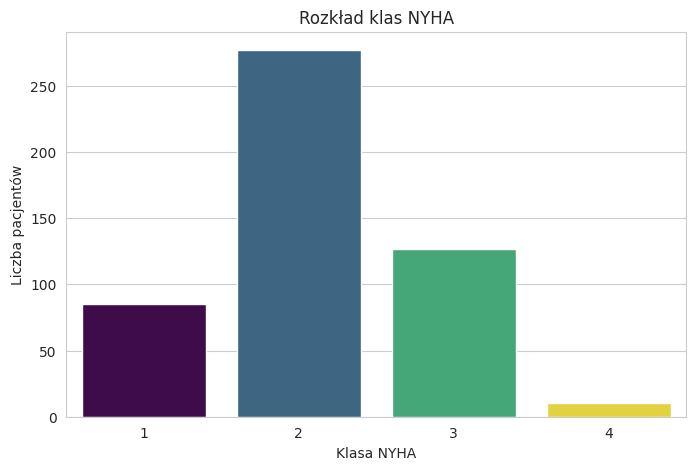

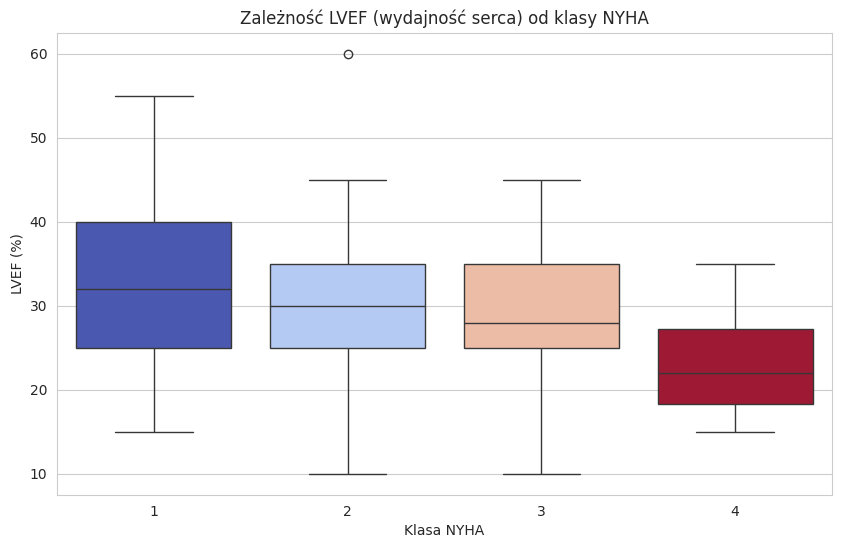

In [7]:
# Wizualizacja danych
sns.set_style("whitegrid")

# Wykres 1: Jak zbalansowana jest nasza zmienna celu (NYHA)?
plt.figure(figsize=(8, 5))
sns.countplot(x='NYHA', data=df_final, palette='viridis', hue='NYHA', legend=False)
plt.title('Rozkład klas NYHA')
plt.xlabel('Klasa NYHA')
plt.ylabel('Liczba pacjentów')
plt.show()

# Wykres 2: Czy LVEF różni się między klasami NYHA?
plt.figure(figsize=(10, 6))
sns.boxplot(x='NYHA', y='LVEF.0', data=df_final, palette='coolwarm', hue='NYHA', legend=False)
plt.title('Zależność LVEF (wydajność serca) od klasy NYHA')
plt.xlabel('Klasa NYHA')
plt.ylabel('LVEF (%)')
plt.show()

Wykresy EDA pokazały, że klasy NYHA są niezbalansowane. Wykres boxplot potwierdził też silną zależność między LVEF a klasą NYHA, im gorsza klasa, tym niższy LVEF.

In [8]:
# Podział na zbiór treningowy i testowy (80/20)
from sklearn.model_selection import train_test_split

X = df_final.drop(columns='NYHA')
y = df_final['NYHA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Celność drzewa decyzyjnego: 0.55


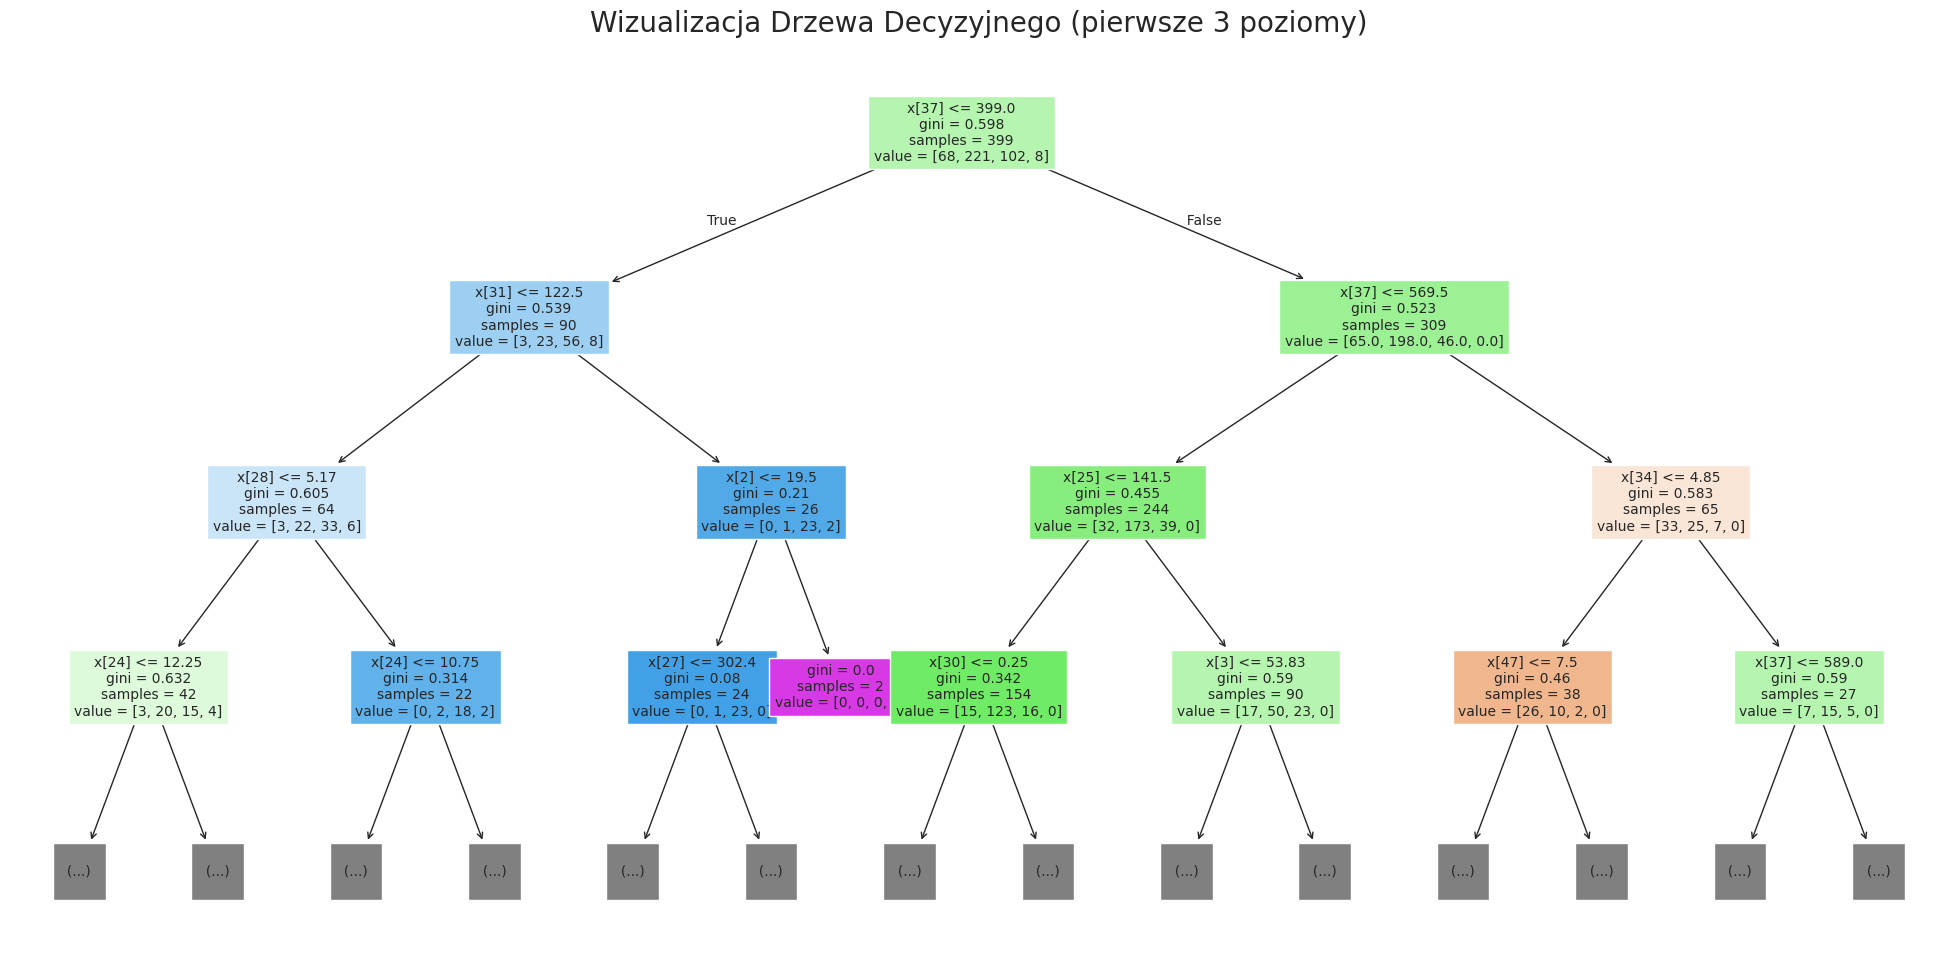

In [9]:
# Tworzymy pierwszy model - drzewo decyzyjne
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

model_drzewo = DecisionTreeClassifier(random_state=42) # random_state=42 zapewnia powtarzalność wyników

# Trenujemy model na danych treningowych
model_drzewo.fit(X_train, y_train)

# Przewidywanie na danych testowych
y_pred_drzewo = model_drzewo.predict(X_test)

# Ocena modelu
acc_drzewo = accuracy_score(y_test, y_pred_drzewo)
print("Celność drzewa decyzyjnego:", acc_drzewo)

# Wizualizacja drzewa
plt.figure(figsize=(25, 12))
plot_tree(model_drzewo,
          max_depth=3,  # rysujemy tylko 3 górne poziomy drzewa
          filled=True,
          fontsize=10)
plt.title("Wizualizacja Drzewa Decyzyjnego (pierwsze 3 poziomy)", fontsize=20)
plt.show()

Model drzewa decyzyjnego osiągnął słabą celność 55%. Wizualizacja drzewa sugeruje przeuczenie modelu.

Celność lasu losowego: 0.73


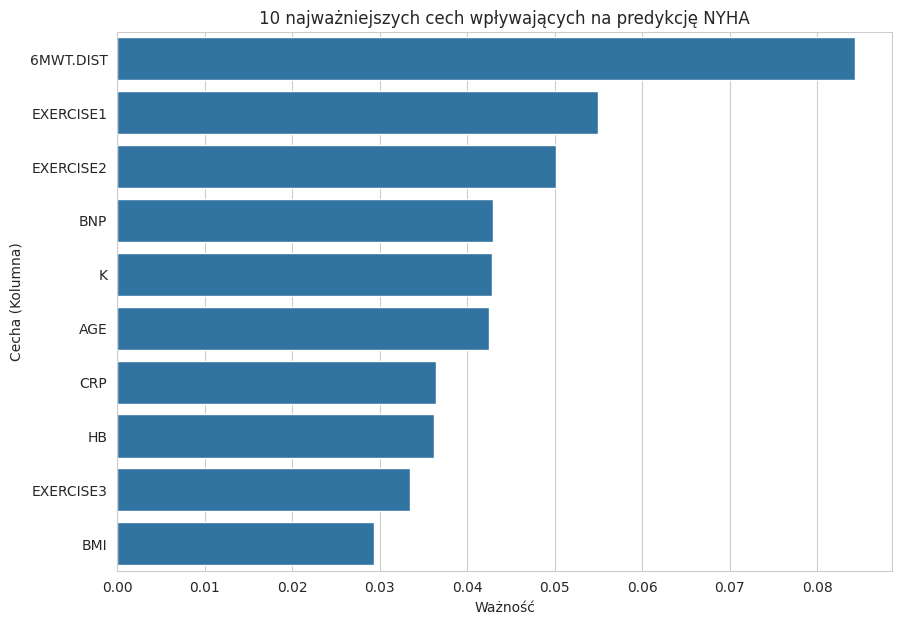

In [10]:
# Tworzymy drugi model - las losowy
from sklearn.ensemble import RandomForestClassifier

# n_estimators=100 oznacza, że budujemy "las" ze 100 drzew
# random_state=42 zapewnia powtarzalność wyników
model_las = RandomForestClassifier(n_estimators=100, random_state=42)

# Trenujemy model na tych samych danych treningowych
model_las.fit(X_train, y_train)

# Przewidywanie na danych testowych
y_pred_las = model_las.predict(X_test)

# Ocena modelu
acc_las = accuracy_score(y_test, y_pred_las)
print("Celność lasu losowego:", acc_las)

# Wizualizacja modelu - wyciągamy "ważność" (importance) każdej cechy z modelu
importances = model_las.feature_importances_

# Tworzymy tabelę, która łączy nazwę cechy z jej ważnością
df_importance = pd.DataFrame({
    'Cecha (Kolumna)': X_train.columns,
    'Ważność': importances})

# Sortujemy od najbardziej ważnej do najmniej ważnej
df_importance = df_importance.sort_values(by='Ważność', ascending=False)

# Wykres słupkowy 10 najważniejszych cech
plt.figure(figsize=(10, 7))
sns.barplot(x='Ważność', y='Cecha (Kolumna)', data=df_importance.head(10))
plt.title('10 najważniejszych cech wpływających na predykcję NYHA')
plt.show()

Las losowy okazał się lepiej dopasowany, celność wynosi 73%. Analiza ważności cech pokazuje, że kluczowe dla modelu było połączenie kluczowych wskaźników kardiologicznych (jak LVEF.0 i BNP), wieku pacjenta, miar sprawności fizycznej (jak 6MWT.DIST) oraz wyników krwi (jak K i HB).

In [11]:
# Przygotowujemy dane do tworzenia trzeciego modelu - regresji logistycznej
from sklearn.preprocessing import StandardScaler

# Tworzymy obiekt StandardScalera
scaler = StandardScaler()

# "Uczymy" skaler na danych treningowych (X_train), oblicza on średnią i odchylenie standardowe dla każdej kolumny w X_train
scaler.fit(X_train)

# Skalujemy dane treningowe używając nauczonych parametrów
X_train_scaled = scaler.transform(X_train)

# Skalujemy dane testowe używając tych samych parametrów z X_train
X_test_scaled = scaler.transform(X_test)

Celność regresji logistycznej: 0.66


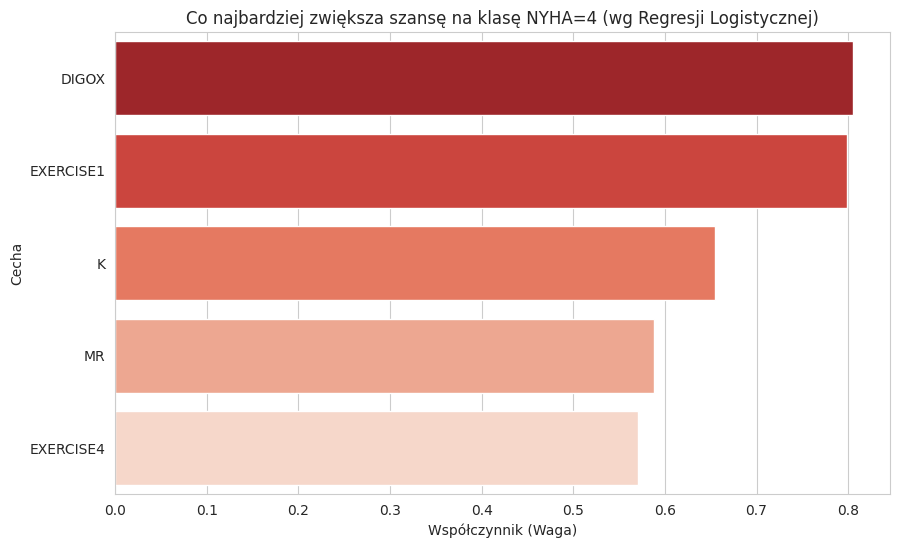

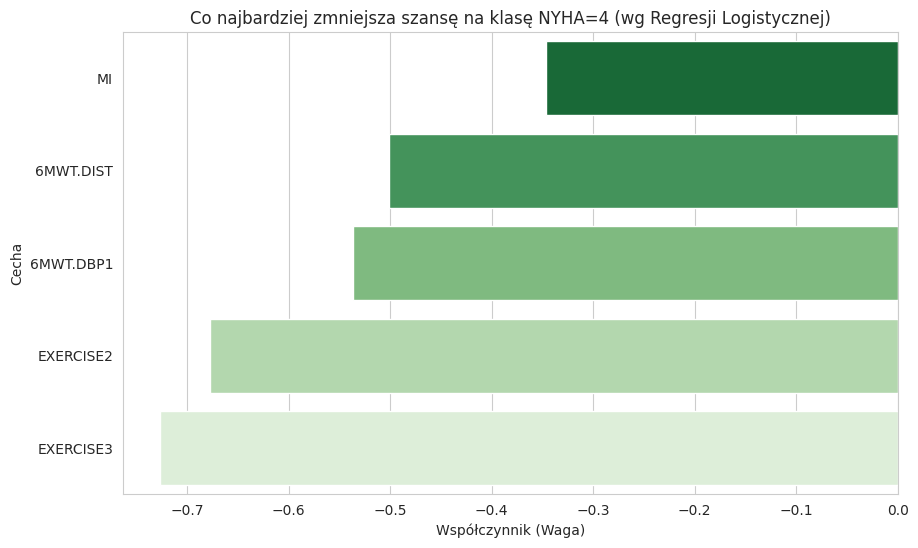

In [12]:
# Tworzymy trzeci model - regresja logistyczna
from sklearn.linear_model import LogisticRegression

# max_iter=1000 daje modelowi więcej czasu na znalezienie najlepszego rozwiązania
model_regresja = LogisticRegression(max_iter=1000, random_state=42)

# Trenujemy model na przeskalowanych danych treningowych
model_regresja.fit(X_train_scaled, y_train)

# Przewidujemy na przeskalowanych danych testowych
y_pred_regresja = model_regresja.predict(X_test_scaled)

# Ocena modelu
acc_regresja = accuracy_score(y_test, y_pred_regresja)
print("Celność regresji logistycznej:", acc_regresja)

# Wizualizacja modelu - pytamy model "Co według ciebie najbardziej wpływa na bycie w klasie 4?"
coefs_class_4 = model_regresja.coef_[3] # coef_[3] oznacza współczynniki dla klasy 4 (bo klasy to 1, 2, 3, 4, a indeksy to 0, 1, 2, 3)

# Łączymy nazwy cech z ich wagami
df_coefs = pd.DataFrame({
    'Cecha': X.columns,
    'Współczynnik (Waga)': coefs_class_4
}).sort_values(by='Współczynnik (Waga)', ascending=False)

# Rysujemy 5 cech, które najbardziej zwiększają ryzyko klasy 4
plt.figure(figsize=(10, 6))
sns.barplot(x='Współczynnik (Waga)', y='Cecha', data=df_coefs.head(5), palette='Reds_r', hue='Cecha', legend=False)
plt.title('Co najbardziej zwiększa szansę na klasę NYHA=4 (wg Regresji Logistycznej)')
plt.show()

# Rysujemy 5 cech, które najbardziej zmniejszają ryzyko klasy 4
plt.figure(figsize=(10, 6))
sns.barplot(x='Współczynnik (Waga)', y='Cecha', data=df_coefs.tail(5), palette='Greens_r', hue='Cecha', legend=False)
plt.title('Co najbardziej zmniejsza szansę na klasę NYHA=4 (wg Regresji Logistycznej)')
plt.show()



Model regresji logistycznej osiągnął 66% celności. Analiza modelu wykazała, że czynnikiem najmocniej zwiększającym szansę na klasę NYHA=4 jest przyjmowanie leku (DIGOX). Natomiast czynnikami najmocniej zmniejszającymi to ryzyko (działającymi "ochronnie") są dobre wyniki w testach sprawnościowych (EXERCISE1 i EXERCISE2).
Porównanie trzech modeli wykazało, że model lasu losowego z celnością 73% jest najskuteczniejszy w przewidywaniu klasy NYHA.